In [71]:
#%pip install -U langgraph langsmith langchain_anthropic
#%pip install langchain_openai

# 1. Configurar el llm con el modelo / deployment que necesitemos
Para construir un agente en LangChain, el primer paso es configurar el LLM (Large Language Model) que utilizará. LangChain admite múltiples proveedores, como OpenAI, Azure OpenAI, Anthropic, Hugging Face, Mistral, entre otros.

Si estamos utilizando Azure OpenAI, es fundamental configurar correctamente el deployment_name o azure_deployment, ya que en Azure no se accede al modelo por su nombre (ej: gpt-4o-mini), sino por el nombre del deployment creado en Azure.

📌 Ver modelos disponibles
Antes de elegir un modelo, puedes ver la lista de modelos disponibles en LangChain:

🔹 Para OpenAI:
📄 Lista de modelos de OpenAI en LangChain

🔹 Para Azure OpenAI:
📄 Documentación de Azure OpenAI en LangChain

Si usas Azure OpenAI, asegúrate de tener acceso a un deployment_name configurado en tu cuenta de Azure.


| Parámetro            | Descripción                                                              |
| -------------------- | ------------------------------------------------------------------------ |
| `azure_deployment`   | Nombre del deployment en Azure OpenAI (no es el nombre del modelo).      |
| `azure_endpoint`     | URL del servicio Azure OpenAI (`https://tu-servicio.openai.azure.com/`). |
| `openai_api_key`     | Clave de API para autenticar la conexión.                                |
| `openai_api_version` | Versión de la API de OpenAI en Azure (ej: `2024-06-01`).                 |
| `temperature`        | Controla la aleatoriedad de las respuestas (0 = determinista).           |


In [98]:
from langchain_openai import AzureChatOpenAI
import os

llm = AzureChatOpenAI(
    azure_deployment="gpt-turbo", 
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  
    openai_api_version="2024-06-01", 
    temperature=0
)


---

# 2. Estado

El estado en LangGraph almacena la información relevante durante la ejecución del agente.
Permite mantener contexto, registrar mensajes y gestionar variables dinámicas.
    thread_id: str  #Hilo que sirve para  ...
    messages: Annotated[List[BaseMessage], add_messages]
    finished: bool variables que se puedan modficiar, puedes ser diccionaros, bools para banderas

🔹 ¿Qué puede incluir el estado?
- messages: Guarda el historial de conversación.
- thread_id (opcional): Identificador del hilo de conversación.
- finished (opcional): Indica si el flujo ha finalizado.
- Variables personalizadas: Puedes añadir flags (bool), contadores (int), o diccionarios (dict) según la lógica del agente.

In [73]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



---

# 3. Nodos
Los nodos en LangGraph representan acciones o procesos dentro del flujo del agente.
Cada nodo puede realizar tareas como llamar al modelo, procesar datos o tomar decisiones.

📌 Un nodo en LangGraph equivale a un "paso" en el flujo del agente.

🔹 ¿Cómo funcionan los nodos?
1. Cada nodo es una función que recibe el state y devuelve un nuevo estado modificado.
2. Se agregan al grafo con graph_builder.add_node(nombre, función).
3. Se conectan mediante bordes (edges), definiendo el flujo del agente.
4. El grafo se compila con graph_builder.compile() para ejecutar el flujo.

In [74]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]} # 


graph_builder.add_node("chatbot", chatbot)

🔹 Definir el flujo del agente con bordes (edges)
Los bordes (edges) conectan los nodos y definen el orden de ejecución.

📌 Esto significa que el grafo:

1. Inicia en START.
2. Ejecuta el nodo chatbot (donde el modelo responde).
3. Termina en END.

In [75]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()


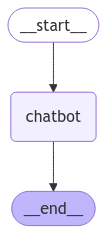

In [76]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Pruebitas

Esta función sirve para probar el grafo, es básicamente un "chatbot".
Se crea un bucle infinito en el que se recoge el input del usuario creado con 'ipywidgets'. Si el usuario no introduce alguna palabra como "quit", se seguirá pidiendo un input.
Cada vez que se recoge la pregunta del usuario se pasa a 'stream_graph_updates', la cual 

In [77]:
import ipywidgets as widgets
from IPython.display import display
import time

# Crear campo de entrada y botón
text_input = widgets.Text(placeholder="Escribe tu mensaje aquí...")
send_button = widgets.Button(description="Enviar")
output_area = widgets.Output()

def stream_graph_updates(user_input: str):
    """Función que envía la entrada del usuario al chatbot y muestra la respuesta."""
    with output_area:
        print(f"User: {user_input}")
    
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            assistant_response = value["messages"][-1].content  
            with output_area:
                print(f"Assistant: {assistant_response}")

def on_button_click(b):
    user_input = text_input.value.strip()
    if user_input.lower() in ["quit", "exit", "q"]:
        with output_area:
            print("Goodbye!")
        return  
    text_input.value = ""  
    stream_graph_updates(user_input)  

send_button.on_click(on_button_click)

display(text_input, send_button, output_area)


Text(value='', placeholder='Escribe tu mensaje aquí...')

Button(description='Enviar', style=ButtonStyle())

Output()

---

# 4. Agregar Tools

Un agente puede usar herramientas (tools) para buscar información externa cuando no conoce la respuesta. En este caso, vamos a integrar Tavily Search, un motor de búsqueda web.

Para eso necesitamos obtener una API Key en: [Tavily](https://app.tavily.com/home?code=sLqr1cdi1FFhQeFmhcExNb3nB0WP0xtgDyTInemKvMPyB&state=eyJyZXR1cm5UbyI6Ii9ob21lIn0)


In [56]:
#%pip install -U tavily-python langchain_community

In [57]:
graph_builder = StateGraph(State)  # 🚀 Nuevo grafo vacío

### Definir la Tool

Importamos la herramienta y la configuramos:

In [58]:
from langchain_community.tools.tavily_search import TavilySearchResults

print(os.getenv("TAVILY_API_KEY"))
# Crear la herramienta de búsqueda
tool = TavilySearchResults(
    max_results=2,
    api_key=os.getenv("TAVILY_API_KEY")
    )
tools = [tool]

# Prueba rápida
print(tool.invoke("¿Qué es un 'nodo' en LangGraph?"))


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
[{'url': 'https://www.studywithgpt.com/es/tutorial/g1161a', 'content': 'A continuación, se abordan los siguientes aspectos en detalle: configuración del entorno, definición de nodos, creación de un StateGraph y la implementación de herramientas y un modelo de chat para la ejecución concurrente. Después de esto, es necesario configurar las claves API para Anthropic, que es el modelo de lenguaje que se utilizará. El tipo principal de gráfico en LangGraph es el StateGraph, que se parametriza mediante un objeto State. Estas herramientas se pueden envolver en un ToolNode, que es una clase sencilla que toma una lista de mensajes, ejecuta las herramientas y devuelve la salida como ToolMessage. Una de las ventajas de usar LangGraph es que es fácil transmitir la salida a medida que se produce en cada nodo.'}, {'url': 'https://www.studywithgpt.com/es/tutorial/u3huzz', 'content': 'A continuación, se explicarán los pasos necesarios para la configuración, la de

### 🤖 Integrar la Tool con el Agente

En LangChain y LangGraph, bind_tools le dice al LLM  que puede usar herramientas (tools) para obtener información externa cuando sea necesario.

🔹 **¿Cómo funciona bind_tools?**

1. Le informa al LLM qué herramientas están disponibles.
2. Le indica cómo formatear la petición a las herramientas.
3. Permite que el modelo decida si usa una tool o responde directamente

In [59]:


#  Modificar el LLM para que pueda llamar herramientas
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


### ¿Cómo el Chatbot Usa Herramientas en LangGraph?

Cuando un LLM tiene herramientas (tools) vinculadas con bind_tools, puede decidir si responde directamente o si necesita llamar una herramienta para obtener información.

Para esto, el LLM genera un tool_call, que indica qué herramienta quiere usar y con qué argumentos.

**¿Qué es un tool_call?**

Es una solicitud que el LLM genera automáticamente cuando necesita usar una herramienta.

Ejemplo de tool_call cuando el usuario pregunta:

**"¿Cuántas personas viven en Tokio?"**

```json
{
    "tool_calls": [
        {
            "name": "TavilySearchResults",
            "args": {"query": "Población actual de Tokio"}
        }
    ]
}
```
Aquí el LLM ha decidido que no conoce la respuesta exacta y ha generado un tool_call para usar TavilySearchResults


**¿Cómo detecta LangGraph los tool_calls?**

1. El nodo del chatbot (chatbot) ejecuta el LLM y obtiene su respuesta.
2. Si la respuesta contiene tool_calls, la función route_tools dirige el flujo al nodo "tools".
3️. El nodo "tools" ejecuta la herramienta y devuelve el resultado.
4️. La respuesta de la herramienta vuelve al chatbot, que decide el siguiente paso.











### **BasicToolNode: Ejecutar herramientas**

Este nodo ejecuta la Tool solicitada por el chatbot.

 **¿Qué hace BasicToolNode?**

1. Busca en el mensaje del chatbot si pidió usar una herramienta.
2. Ejecuta la Tool solicitada y obtiene la respuesta.
3. Devuelve la información en el estado (state), para que el chatbot la use.

In [60]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### ¿Qué hace route_tools? 

La función route_tools determina si el chatbot debe llamar una herramienta o finalizar la conversación.

###  **¿Cómo funciona?**

Si el chatbot no necesita herramientas, finaliza (END).
Si el chatbot necesita una tool, dirige el flujo al nodo "tools".

###  **¿Qué hacen estos edges?**

1. route_tools decide si ir a "tools" o terminar (END).`
2. Si el chatbot usa una Tool, va al nodo "tools".
3. Cuando termina de usar una Tool, vuelve al "chatbot".
4. El flujo empieza en "chatbot" (START → chatbot)

In [61]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

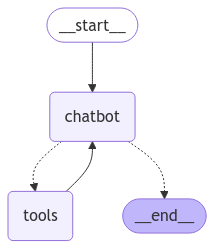

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Probar el chatbot

In [63]:
# Definir la pregunta de prueba
user_input = "Cuándo fue la última actualización de langchain?"

# Estado inicial con la pregunta del usuario
conversation_state = {"messages": [{"role": "user", "content": user_input}]}

graph_events = list(graph.stream(conversation_state))

# Mostrar todos los mensajes generados en el flujo de conversación
print("\n--- Conversación con el chatbot ---\n")
for event in graph_events:
    for value in event.values():
        for message in value["messages"]:
            
            # 🔍 1. Si el chatbot genera una tool_call
            if hasattr(message, "tool_calls") and message.tool_calls:
                print("🔹 El chatbot ha usado una herramienta.")
                for tool_call in message.tool_calls:
                    print(f"🔧 Herramienta llamada: {tool_call['name']}")
                    print(f"📌 Argumentos usados: {tool_call['args']} \n")

            # 🔍 2. Si el chatbot muestra una respuesta en JSON (ToolMessage)
            elif hasattr(message, "name") and message.name:
                print(f"📄 Respuesta cruda de la herramienta ({message.name}):")
                print(message.content)  # Esto es el JSON que devuelve la tool
                print("")

            # 🔍 3. Si es una respuesta normal del chatbot
            else:
                print(f"✅ Respuesta final del chatbot: {message.content} \n")




--- Conversación con el chatbot ---

🔹 El chatbot ha usado una herramienta.
🔧 Herramienta llamada: tavily_search_results_json
📌 Argumentos usados: {'query': 'última actualización de langchain'} 

📄 Respuesta cruda de la herramienta (tavily_search_results_json):
[{"url": "https://github.com/langchain-ai/langchain/releases", "content": "Releases \u00b7 langchain-ai/langchain \u00b7 GitHub GitHub Copilot Enterprise-grade AI features Search code, repositories, users, issues, pull requests... Search Releases: langchain-ai/langchain Releases \u00b7 langchain-ai/langchain langchain-tests==0.3.1 github-actions langchain-tests==0.3.1 langchain-tests==0.3.1 Changes since langchain-tests==0.3.0 langchain-tests==0.3.0 langchain-tests==0.3.0 langchain-tests==0.3.0 Latest Initial langchain-tests release langchain-core==0.3.19 github-actions langchain-core==0.3.19 langchain-core==0.3.19 Changes since langchain-core==0.3.18 core: release 0.3.19 (#28137) github-actions langchain-core==0.3.18 github-ac

# 5. Memoria

Actualmente, nuestro chatbot puede responder preguntas y usar herramientas, pero no recuerda conversaciones anteriores. Esto significa que cada vez que se le pregunta algo, actúa como si fuera la primera vez que habla contigo.

Para solucionar esto, LangGraph usa "checkpointing", que guarda el estado del chatbot después de cada interacción. Con esto, el chatbot puede recordar información y mantener conversaciones coherentes en múltiples turnos.

### 1. Argeagar un Checkpointer
Un checkpointer es un mecanismo que guarda el estado del chatbot después de cada interacción. Esto permite que el chatbot recuerde conversaciones pasadas sin necesidad de almacenar manualmente los mensajes.

-  Sin checkpointer: Cada interacción es independiente y el chatbot no recuerda nada.
-  Con checkpointer: El chatbot guarda el estado y puede recordar información previa.

In [64]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

### 2. MemorySaver

LangGraph ofrece varias formas de guardar el estado.
En este caso, usamos MemorySaver(), que almacena la memoria en RAM.

MemorySaver() solo guarda datos mientras el programa está en ejecución.
Si cierras el programa, se pierde la memoria.

🔹 Para almacenamiento persistente, se puede usar:

- SqliteSaver() → Guarda los datos en una base de datos SQLite.
- PostgresSaver() → Usa PostgreSQL para almacenar memoria a largo plazo.

In [65]:
graph = graph_builder.compile(checkpointer=memory)

### 3. Config y thread_id

LangGraph necesita un identificador para saber a qué conversación pertenece cada mensaje.
Este identificador se llama thread_id y se pasa dentro de config.

📌 **¿Cómo funciona?**
- Si usas el mismo thread_id, el chatbot recordará la conversación.
- Si cambias el thread_id, el chatbot olvidará todo y comenzará de nuevo.


In [66]:
config = {"configurable": {"thread_id": "1"}}

In [67]:
user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [68]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. How can I help you, Will?


In [69]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm sorry, but as an AI assistant, I don't have the capability to remember personal information about individuals.


In [ ]:
#graph_builder = StateGraph(State)  # 🚀 Nuevo grafo vacío
import ipywidgets as widgets
from IPython.display import display


# Crear campo de entrada y botón
text_input = widgets.Text(placeholder="Escribe tu mensaje aquí...")
send_button = widgets.Button(description="Enviar")
output_area = widgets.Output()

# Configuración para el checkpointer (requerida si el grafo tiene memoria)
config = {"configurable": {"thread_id": "session_1"}}  # Cambia session_1 por cualquier ID único

def stream_graph_updates(user_input: str):
    """Envía la entrada del usuario al chatbot y muestra la respuesta."""
    with output_area:
        print(f"User: {user_input}")
    
    # Ahora pasamos `config` como segundo argumento
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},  
        config  # 🚀 Se pasa la configuración con thread_id
    ):
        for value in event.values():
            assistant_response = value["messages"][-1].content  
            with output_area:
                print(f"Assistant: {assistant_response}")

def on_button_click(b):
    user_input = text_input.value.strip()
    if user_input.lower() in ["quit", "exit", "q"]:
        with output_area:
            print("Goodbye!")
        return  
    text_input.value = ""  
    stream_graph_updates(user_input)  

send_button.on_click(on_button_click)

display(text_input, send_button, output_area)

# 6. Human in the loop

A veces, los agentes pueden cometer errores o necesitar aprobación antes de ejecutar una acción. LangGraph permite pausar la ejecución del chatbot y esperar una respuesta humana antes de continuar. Para ello, utilizamos la función interrupt() dentro de una herramienta (tool).

🛠️ **Añadiendo una herramienta de asistencia humana**

Creamos una herramienta que detiene la ejecución hasta recibir la respuesta de un humano:

In [81]:
from langchain_core.tools import tool
from langgraph.types import interrupt

@tool
def human_assistance(query: str) -> str:
    """Solicita ayuda de un humano."""
    human_response = interrupt({"query": query})
    return human_response["data"]



**Cómo funciona el flujo Human-in-the-loop**

Ejemplo de un chatbot camarero que espera a que un cocinero acepte el pedido

In [87]:
from typing import Annotated
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Definir el estado del chatbot
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Herramienta para validar pedido
@tool
def validar_pedido(pedido: str) -> str:
    """Pide al cocinero que valide el pedido antes de confirmarlo."""
    respuesta = interrupt({"pedido": pedido})  # Pausa hasta recibir confirmación
    return respuesta["data"]

tools = [validar_pedido]

# Definir el chatbot
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

# Nodo de herramientas
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 🔹 **Función condicional para decidir el flujo**
def route_validation(state: State):
    """Si el chatbot ha solicitado la validación de un pedido, ir al nodo de herramientas."""
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None

    if last_message and hasattr(last_message, "tool_calls"):
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "validar_pedido":
                return "tools"  # Si el chatbot pidió validación, ir al nodo "tools"
    return END  # Si no hay validación, el flujo termina aquí.

# Agregar edges condicionales
graph_builder.add_conditional_edges("chatbot", route_validation, {"tools": "tools", END: END})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compilar el grafo
graph = graph_builder.compile(checkpointer=memory)


In [88]:
# Simulación de conversación
config = {"configurable": {"thread_id": "1"}}
user_input = "Quiero una pizza margarita."

# 1️⃣ Cliente hace el pedido
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    print(event["messages"][-1].content)  # Mensaje del chatbot

# 2️⃣ Cocinero confirma el pedido
cocinero_respuesta = "Pedido aceptado. Estará listo en 20 minutos."
command = Command(resume={"data": cocinero_respuesta})

events = graph.stream(command, config, stream_mode="values")
for event in events:
    print(event["messages"][-1].content)  # Mensaje final del chatbot


Quiero una pizza margarita.


Pedido aceptado. Estará listo en 20 minutos.
Tu pedido de pizza margarita ha sido aceptado. Estará listo en 20 minutos. ¡Disfrútala!


---

# 7. Personalización del Estado en LangGraph

Hasta ahora, nuestro chatbot solo ha manejado mensajes. Sin embargo, LangGraph nos permite agregar más información al estado, lo que facilita flujos de trabajo más complejos sin depender solo de la lista de mensajes.

En este ejemplo, el chatbot busca información sobre una fecha y permite que un humano revise la respuesta antes de confirmarla.

🛠 **Cómo Personalizar el Estado**

Podemos agregar nuevos campos al estado usando un TypedDict con claves personalizadas.


### 🍽️ **Ejemplo: Chatbot Camarero con Aprobación del Cocinero**


Imaginemos un chatbot que toma pedidos de los clientes en un restaurante. Antes de confirmar el pedido, debe esperar la validación del cocinero. Usaremos LangGraph para manejar la interrupción y esperar la aprobación del cocinero.

🔧 **Paso 1: Definir el Estado**

Agregamos campos personalizados al estado para almacenar el pedido y su estado de validación.

In [92]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]  # Historial de mensajes
    order: str  # Pedido del cliente
    status: str  # Estado del pedido (pendiente, aprobado, rechazado)

### 🛠 **Paso 2: Herramienta de Validación del Cocinero**

Creamos una herramienta que pausa el flujo y espera la aprobación del cocinero antes de confirmar el pedido.

1. **`interrupt()`** pausa la ejecución hasta que el cocinero apruebe o rechace el pedido.
2. Si el cocinero **aprueba** el pedido, el estado se actualiza con `"status": "aprobado"`.
3. Si **rechaza**, se guarda `"status": "rechazado"` junto con la razón proporcionada.
4. La información se devuelve como un **Command** para actualizar el estado.

In [103]:
from langchain_core.messages import ToolMessage
from langgraph.types import Command, interrupt
from langchain_core.tools import InjectedToolCallId, tool

@tool
def validar_pedido(pedido: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
    """Simula la validación de un pedido por parte del cocinero."""
    respuesta_humana = interrupt(
        {
            "question": f"¿El cocinero aprueba el pedido '{pedido}'?",
            "pedido": pedido
        }
    )
    
    if respuesta_humana.get("approved", "").lower() == "yes":
        estado_pedido = "Pedido aprobado por el cocinero."
    else:
        estado_pedido = "Pedido rechazado por el cocinero."

    # ✅ Incluir ToolMessage en la actualización del estado
    return Command(
        update={
            "messages": [
                ToolMessage(content=estado_pedido, tool_call_id=tool_call_id)
            ]
        }
    )



### 🍔 **Paso 3: Crear el Chatbot y el Grafo**

Definimos el chatbot, agregamos la herramienta y construimos el grafo.

In [1]:
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
import os


llm = AzureChatOpenAI(
    azure_deployment="gpt-turbo", 
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  
    openai_api_version="2024-06-01", 
    temperature=0
)

llm_with_tools = llm.bind_tools([validar_pedido])

# 🔹 Definir chatbot
def chatbot(state: State):
    """Maneja la interacción del chatbot."""
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# 🔹 Construcción del grafo
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# Nodo para validar pedido
tool_node = ToolNode(tools=[validar_pedido])
graph_builder.add_node("tools", tool_node)

# 🔹 Definir flujo de ejecución
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 🔹 Habilitar memoria
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


NameError: name 'os' is not defined

### Paso 4: Probar el Chatbot Camarero

In [104]:
user_input = "Quiero una pizza margarita."
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Quiero una pizza margarita.


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_cYYsqY4NRZMTK5n3vaqAgopV", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}

In [102]:
cocinero_respuesta = Command(
    resume={
        "approved": "yes"
    }
)
events = graph.stream(cocinero_respuesta, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  validar_pedido (call_cYYsqY4NRZMTK5n3vaqAgopV)
 Call ID: call_cYYsqY4NRZMTK5n3vaqAgopV
  Args:
    order: pizza margarita


ValueError: Expected to have a matching ToolMessage in Command.update for tool 'validar_pedido', got: [HumanMessage(content="Pedido 'pizza margarita' aprobado por el cocinero.", additional_kwargs={}, response_metadata={})]. Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage. You can fix it by modifying the tool to return `Command(update={"messages": [ToolMessage("Success", tool_call_id=tool_call_id), ...]}, ...)`.